# Convergence Analysis

## Table of Contents
* [1) Checking Approximation for Increasing Number of Knot Points](#first-bullet)
* [2) Dynamic Chebyshev Convergence](#second-bullet)
    - [Reference Algorithm](#seconda-bullet)
    - [Varying Number of Nodal Points](#secondd-bullet)
    - [Varying Number of Steps](#secondc-bullet)
    - [Varying Number of Simulated Paths](#secondd-bullet)
    - [Plot to be Put in Assignment](#seconde-bullet)

## Setup

In [104]:
%load_ext autoreload
%autoreload 2

import scipy.sparse
import scipy.sparse.linalg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
from DC import DynamicChebyshev
from LSM import MonteCarloOptionPricing
from FD import AmericanPutFiniteDifference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Run code

In [105]:
# initialize instance from class
DC_option_pricing = DynamicChebyshev(r=0.06, S0=36., K=40., T=1., σ=0.2, λ=0.4, dim=10_000, n=252, n_chebyshev_pol=100, seed=150_000)

# offline phase
domain = DC_option_pricing.calculate_truncated_domain_GBM()
xknots = DC_option_pricing.calculate_nodal_points(domain)
BS = DC_option_pricing.generate_GBM_path(xknots)
Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)

# online phase
DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]

array(4.85908753)

# 1) Checking Approximation for Increasing Number of Knot Points <a class="anchor" id="first-bullet"></a>

In [106]:
# Placeholder price list
price = []

# Loop for the MonteCarloOptionPricing
for S0 in np.arange(20, 70, 0.2):
    mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=S0, K=40., T=1., σ=0.2, λ=0.4, dim=1_000, n=252, seed=150_000)
    simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
    mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')
    price.append(mc_option_pricing.C.mean())

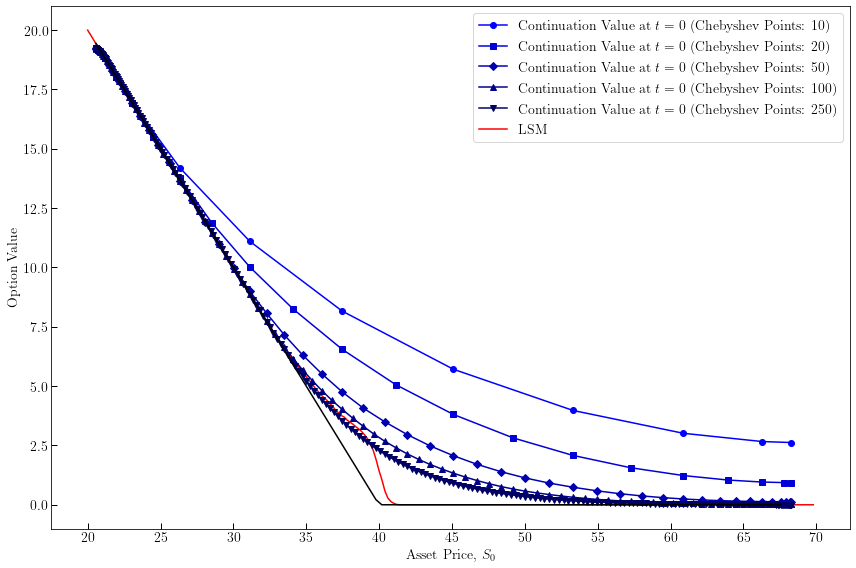

In [107]:
# Define the array of number of Chebyshev points to loop over
chebyshev_points_array = [10, 20, 50, 100, 250] 

# Initialize the figure for plotting
plt.figure(figsize=(12, 8))

# Generate shades of blue
# Darker shades for more Chebyshev points
num_points = len(chebyshev_points_array)
blue_shades = ["#%02x%02x%02x" % (0, 0, 255 - int(155 * i/(num_points - 1))) for i in range(num_points)]

# Add the MonteCarloOptionPricing results to the plot
plt.plot(np.arange(20, 70, 0.2), price, linestyle='-', color='r', label='LSM')

# Loop over the array of Chebyshev points
for idx, n_chebyshev_pol in enumerate(chebyshev_points_array):
    # Initialize the DynamicChebyshev object with the current number of Chebyshev points
    DC_option_pricing = DynamicChebyshev(r=0.06, S0=36., K=40., T=1., σ=0.2, λ=0.4, dim=10_000, n=252, 
                                      n_chebyshev_pol=n_chebyshev_pol, seed=150_000)

    # offline phase
    domain = DC_option_pricing.calculate_truncated_domain_GBM()
    xknots = DC_option_pricing.calculate_nodal_points(domain)
    BS = DC_option_pricing.generate_GBM_path(xknots)
    Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)

    # online phase
    DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)

    # Plot the continuation value at t=0 for each number of Chebyshev points
    plt.plot(np.exp(xknots), DC_option_pricing.C[:,0], linestyle='-', color=blue_shades[idx], marker=markers[idx % len(markers)], label=f'Continuation Value at $t=0$ (Chebyshev Points: {n_chebyshev_pol})')

# Plot the intrinsic value 
asset_prices_range = np.exp(np.arange(domain[0], domain[1], 0.01))
put_value = np.maximum(DC_option_pricing.K - asset_prices_range, 0)
plt.plot(asset_prices_range, put_value, '-k', label='American Put Value')  # 'k' for black color

# Adding labels and title
plt.xlabel('Asset Price, $S_0$', fontsize=14)
plt.ylabel('Option Value', fontsize=14)
#plt.title('Dynamic Chebyshev Method - Computed using MC for Different Chebyshev Points', fontsize=16)

# After all plotting commands (but before plt.show or plt.savefig):
handles, labels = plt.gca().get_legend_handles_labels()

# Manually define the order of your labels, for example:
desired_order = ['Continuation Value at $t=0$ (Chebyshev Points: 10)', 'Continuation Value at $t=0$ (Chebyshev Points: 20)', 'Continuation Value at $t=0$ (Chebyshev Points: 50)', 'Continuation Value at $t=0$ (Chebyshev Points: 100)', 'Continuation Value at $t=0$ (Chebyshev Points: 250)', 'LSM','Put Value']

# Create a dictionary to map the current labels to their handles
label_handle_map = dict(zip(labels, handles))

# Reorder handles using the desired order
ordered_handles = [label_handle_map[label] for label in desired_order if label in label_handle_map]

# Create the legend with the ordered handles and labels
plt.legend(ordered_handles, desired_order, fontsize=14)

plt.xticks(np.arange(20, 75, 5))

# Customize tick marks
plt.tick_params(axis='both',          
                direction='in',       
                length=6,             
                width=1,              
                colors='black',       
                grid_alpha=0.5,       
               labelsize=14)       

plt.tight_layout()

if not os.path.exists("../Results/plots"):
    os.makedirs("../Results/plots")
    
plt.savefig("../Results/plots/DC_approximation.pdf", bbox_inches='tight')

# Dynamic Chebyshev Convergence <a class="anchor" id="second-bullet"></a>

## Reference Algorithm <a class="anchor" id="seconda-bullet"></a>

In [39]:
implicit_FD = AmericanPutFiniteDifference(K = 40., r=0.06, M = 1_000)

In [40]:
# Combinations of S0, σ, and T
combinations = [
    (36, 0.20, 1), (36, 0.20, 2), (36, 0.40, 1), (36, 0.40, 2),
    (38, 0.20, 1), (38, 0.20, 2), (38, 0.40, 1), (38, 0.40, 2),
    (40, 0.20, 1), (40, 0.20, 2), (40, 0.40, 1), (40, 0.40, 2),
    (42, 0.20, 1), (42, 0.20, 2), (42, 0.40, 1), (42, 0.40, 2),
    (44, 0.20, 1), (44, 0.20, 2), (44, 0.40, 1), (44, 0.40, 2)
]

# Calculate prices
results = implicit_FD.option_pricing(combinations, N=50) # timestep = 50

# Convert results to a DataFrame for better visualization
df = pd.DataFrame(results)
print(df)

    S0    σ  Maturity     Price
0   36  0.2         1  4.464959
1   36  0.2         2  4.829426
2   36  0.4         1  7.075359
3   36  0.4         2  8.414515
4   38  0.2         1  3.236798
5   38  0.2         2  3.734485
6   38  0.4         1  6.122398
7   38  0.4         2  7.593174
8   40  0.2         1  2.301416
9   40  0.2         2  2.875075
10  40  0.4         1  5.287724
11  40  0.4         2  6.855543
12  42  0.2         1  1.606117
13  42  0.2         2  2.203934
14  42  0.4         1  4.559553
15  42  0.4         2  6.193117
16  44  0.2         1  1.101470
17  44  0.2         2  1.682617
18  44  0.4         1  3.926463
19  44  0.4         2  5.598173


## Varying Number of Nodal Points <a class="anchor" id="secondb-bullet"></a>

In [101]:
# Parameters to vary
varying_params = [10, 20, 50, 100, 250]  # Example values
seeds = [150000, 200000, 250000, 300000]  # Different seeds

known_price = 4.464959  # from reference algo
log_errors = []

for param in varying_params:
    errors = []
    for seed in seeds:
        DC_option_pricing = DynamicChebyshev(r=0.06, S0=36., K=40., T=1., σ=0.2, λ=0.4, dim=10_000, n=252, n_chebyshev_pol=param, seed=seed)
        # offline phase
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        # online phase
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)[0]
        
        # Calculate error for this seed
        error = abs(DC_price - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error = np.mean(errors)
    log_avg_error = np.log10(avg_error) if avg_error > 0 else None
    log_errors.append(log_avg_error)

KeyboardInterrupt: 

## Varying Number of Steps <a class="anchor" id="secondc-bullet"></a>

## Varying Number of Simulated Paths <a class="anchor" id="secondd-bullet"></a>

## Plot to be Put in Assignment <a class="anchor" id="seconde-bullet"></a>

ValueError: x and y must have same first dimension, but have shapes (5,) and (2,)

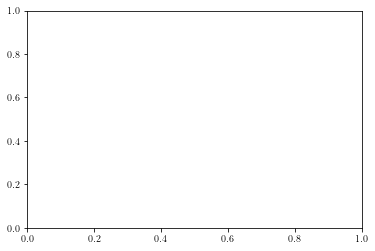

In [102]:
# Plotting your errors
plt.plot(varying_params, log_errors)  # Use varying_params for x-axis
plt.xlabel('Number of Path Simulations')
plt.ylabel('Log-Error')

plt.show()

### LSM

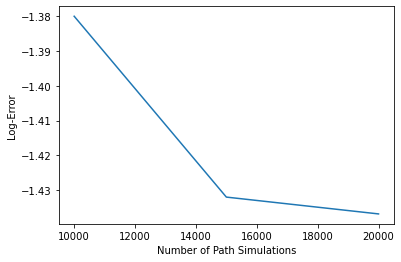

In [23]:
# Parameters to vary 
varying_params = [10_000, 15_000, 20_000]  # Example values
seeds = [150000, 200000, 250000, 300000]  # Different seeds

known_price = 4.464959  # from reference algo
log_errors = []

for param in varying_params:
    errors = []
    for seed in seeds:
        # Initialize with different seeds
        mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=1., σ=0.2, λ=0.4, dim=param, n=252, seed=seed)
        simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
        mc_price = mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')
        
        # Calculate error for this seed
        error = abs(mc_price[0] - known_price)
        errors.append(error)

    # Calculate average error for this param
    avg_error = np.mean(errors)
    log_avg_error = np.log10(avg_error) if avg_error > 0 else None
    log_errors.append(log_avg_error)

# Plotting your errors
plt.plot(varying_params, log_errors)  # Use varying_params for x-axis
plt.xlabel('Number of Path Simulations')
plt.ylabel('Log-Error')

plt.show()

In [ ]:
# Define the array of number of Chebyshev points to loop over
chebyshev_points_array = [10, 20, 50, 100, 250] 

# Initialize the figure for plotting
plt.figure(figsize=(12, 8))

# Generate shades of blue
# Darker shades for more Chebyshev points
num_points = len(chebyshev_points_array)
blue_shades = ["#%02x%02x%02x" % (0, 0, 255 - int(155 * i/(num_points - 1))) for i in range(num_points)]

# Add the MonteCarloOptionPricing results to the plot
plt.plot(np.arange(20, 70, 0.2), price, linestyle='-', color='r', label='LSM')

# Loop over the array of Chebyshev points
for idx, n_chebyshev_pol in enumerate(chebyshev_points_array):
    # Initialize the DynamicChebyshev object with the current number of Chebyshev points
    DC_option_pricing = DynamicChebyshev(r=0.06, S0=36., K=40., T=1., σ=0.2, λ=0.4, dim=10_000, n=252, 
                                      n_chebyshev_pol=n_chebyshev_pol, seed=150_000)

    # offline phase
    domain = DC_option_pricing.calculate_truncated_domain_GBM()
    xknots = DC_option_pricing.calculate_nodal_points(domain)
    BS = DC_option_pricing.generate_GBM_path(xknots)
    Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)

    # online phase
    DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)

    # Plot the continuation value at t=0 for each number of Chebyshev points
    plt.plot(np.exp(xknots), DC_option_pricing.C[:,0], linestyle='-', color=blue_shades[idx], marker=markers[idx % len(markers)], label=f'Continuation Value at $t=0$ (Chebyshev Points: {n_chebyshev_pol})')

# Plot the intrinsic value 
asset_prices_range = np.exp(np.arange(domain[0], domain[1], 0.01))
put_value = np.maximum(DC_option_pricing.K - asset_prices_range, 0)
plt.plot(asset_prices_range, put_value, '-k', label='Put Value')  # 'k' for black color

# Adding labels and title
plt.xlabel('Asset Price, $S_0$', fontsize=14)
plt.ylabel('Option Value', fontsize=14)
#plt.title('Dynamic Chebyshev Method - Computed using MC for Different Chebyshev Points', fontsize=16)

# After all plotting commands (but before plt.show or plt.savefig):
handles, labels = plt.gca().get_legend_handles_labels()

# Manually define the order of your labels, for example:
desired_order = ['Continuation Value at $t=0$ (Chebyshev Points: 10)', 'Continuation Value at $t=0$ (Chebyshev Points: 20)', 'Continuation Value at $t=0$ (Chebyshev Points: 50)', 'Continuation Value at $t=0$ (Chebyshev Points: 100)', 'Continuation Value at $t=0$ (Chebyshev Points: 250)', 'LSM','Put Value']

# Create a dictionary to map the current labels to their handles
label_handle_map = dict(zip(labels, handles))

# Reorder handles using the desired order
ordered_handles = [label_handle_map[label] for label in desired_order if label in label_handle_map]

# Create the legend with the ordered handles and labels
plt.legend(ordered_handles, desired_order, fontsize=14)

plt.xticks(np.arange(20, 75, 5))

# Customize tick marks
plt.tick_params(axis='both',          
                direction='in',       
                length=6,             
                width=1,              
                colors='black',       
                grid_alpha=0.5,       
               labelsize=14)       

plt.tight_layout()

if not os.path.exists("../Results/plots"):
    os.makedirs("../Results/plots")
    
plt.savefig("../Results/plots/DC_approximation.pdf", bbox_inches='tight')